In [7]:
#!pip install mlflow torch torchvision scikit-learn matplotlib

2025/01/21 07:17:26 INFO mlflow.tracking.fluent: Experiment with name 'MLflow_PyTorch_Configurations' does not exist. Creating a new experiment.


Metrics saved for Config_1.
Metrics saved for Config_2.
Metrics saved for Config_3.


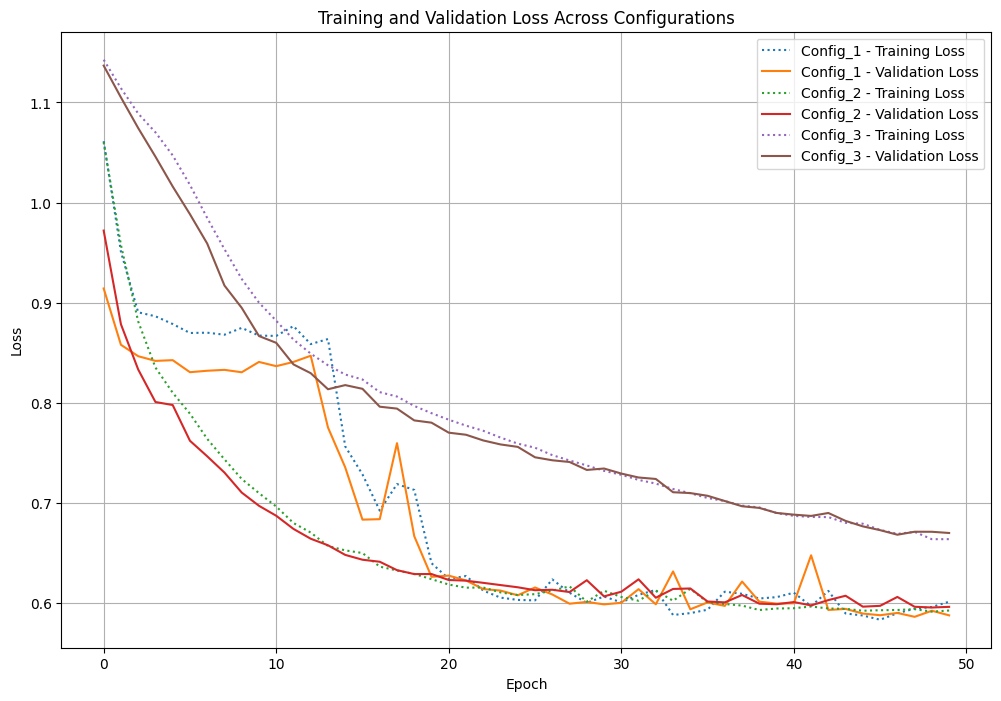

In [13]:
import mlflow
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import os
import json
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from torch.utils.data import DataLoader, TensorDataset

# Configure MLflow for local storage
mlflow.set_tracking_uri("file:///content/mlruns")
mlflow.set_experiment("MLflow_PyTorch_Configurations")

# Load Iris dataset
data = load_iris()
X = data['data']
y = data['target']

# One-hot encode the target
encoder = OneHotEncoder(sparse_output=False)
y = encoder.fit_transform(y.reshape(-1, 1))

# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

# Create DataLoader
def get_data_loader(X, y, batch_size):
    dataset = TensorDataset(X, y)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Define a simple PyTorch model
class SimpleNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return self.softmax(x)

# Directory to store results
output_dir = "/content/ml_results"
os.makedirs(output_dir, exist_ok=True)

# Define configurations to compare
configurations = [
    {"hidden_dim": 64, "learning_rate": 0.01, "batch_size": 16, "epochs": 50, "name": "Config_1"},
    {"hidden_dim": 128, "learning_rate": 0.005, "batch_size": 32, "epochs": 50, "name": "Config_2"},
    {"hidden_dim": 32, "learning_rate": 0.001, "batch_size": 8, "epochs": 50, "name": "Config_3"},
]

# Train and log each configuration
for config in configurations:
    with mlflow.start_run(run_name=config["name"]):
        # Initialize the model, loss, and optimizer
        model = SimpleNN(X_train.shape[1], config["hidden_dim"], y_train.shape[1])
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"])
        train_loader = get_data_loader(X_train, y_train, config["batch_size"])
        val_loader = get_data_loader(X_val, y_val, config["batch_size"])

        train_losses = []
        val_losses = []

        # Training loop
        for epoch in range(config["epochs"]):
            model.train()
            train_loss = 0.0

            for X_batch, y_batch in train_loader:
                optimizer.zero_grad()
                outputs = model(X_batch)
                loss = criterion(outputs, torch.argmax(y_batch, dim=1))
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

            train_loss /= len(train_loader)
            train_losses.append(train_loss)

            # Validation loop
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for X_batch, y_batch in val_loader:
                    outputs = model(X_batch)
                    loss = criterion(outputs, torch.argmax(y_batch, dim=1))
                    val_loss += loss.item()

            val_loss /= len(val_loader)
            val_losses.append(val_loss)

            # Log metrics for this epoch
            mlflow.log_metric("train_loss", train_loss, step=epoch)
            mlflow.log_metric("val_loss", val_loss, step=epoch)

        # Log final metrics and parameters
        mlflow.log_param("hidden_dim", config["hidden_dim"])
        mlflow.log_param("learning_rate", config["learning_rate"])
        mlflow.log_param("batch_size", config["batch_size"])
        mlflow.log_param("epochs", config["epochs"])

        # Save metrics to JSON for visualization
        results = {"train_loss": train_losses, "val_loss": val_losses}
        with open(f"{output_dir}/{config['name']}_metrics.json", "w") as f:
            json.dump(results, f)
        print(f"Metrics saved for {config['name']}.")

# ---------------------------------------
# Visualization (Independent from Training)
# ---------------------------------------

# Load metrics from JSON files
all_results = {}
for config in configurations:
    with open(f"{output_dir}/{config['name']}_metrics.json", "r") as f:
        all_results[config["name"]] = json.load(f)

# Plot training and validation loss for all configurations
plt.figure(figsize=(12, 8))
for name, data in all_results.items():
    plt.plot(data["train_loss"], linestyle='dotted', label=f"{name} - Training Loss")
    plt.plot(data["val_loss"], linestyle='solid', label=f"{name} - Validation Loss")
plt.title("Training and Validation Loss Across Configurations")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


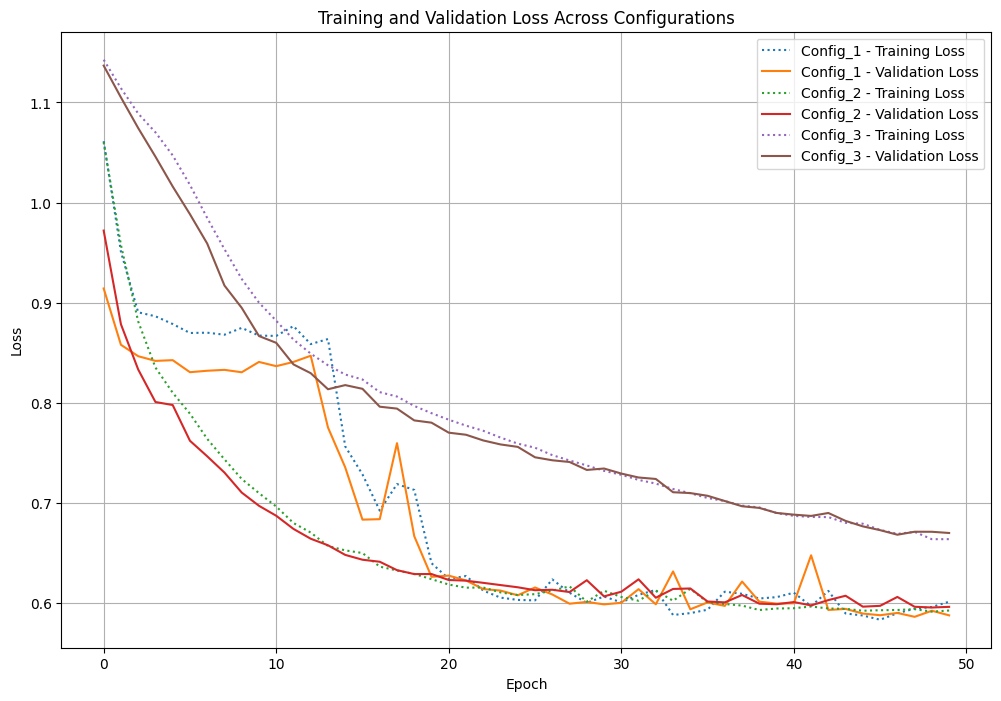

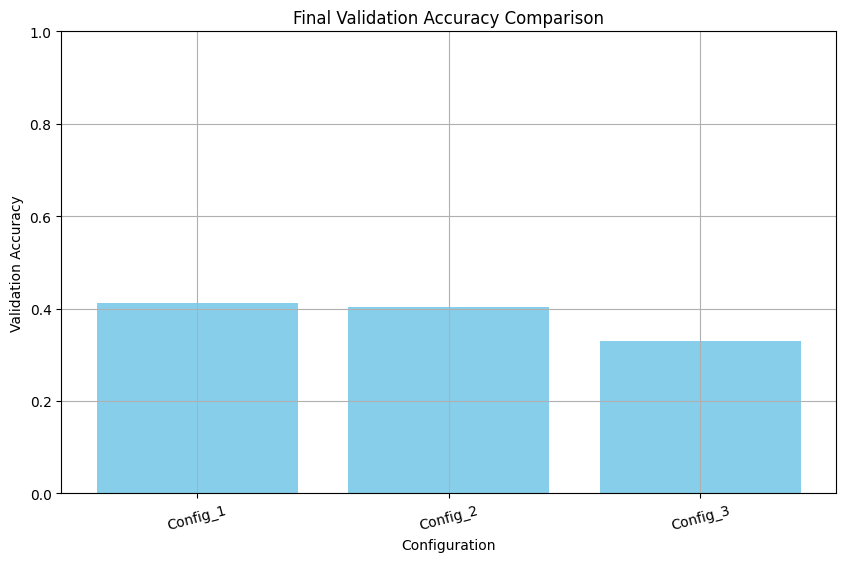

In [14]:
# ---------------------------------------
# Final Visualization: Comparing Configurations
# ---------------------------------------

# Plot training and validation loss for all configurations
plt.figure(figsize=(12, 8))
for name, data in all_results.items():
    plt.plot(data["train_loss"], linestyle='dotted', label=f"{name} - Training Loss")
    plt.plot(data["val_loss"], linestyle='solid', label=f"{name} - Validation Loss")
plt.title("Training and Validation Loss Across Configurations")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# Bar plot for final validation accuracy
final_val_accuracies = [1 - data["val_loss"][-1] for data in all_results.values()]  # Approx. accuracy
names = list(all_results.keys())

plt.figure(figsize=(10, 6))
plt.bar(names, final_val_accuracies, color='skyblue')
plt.title("Final Validation Accuracy Comparison")
plt.xlabel("Configuration")
plt.ylabel("Validation Accuracy")
plt.ylim(0, 1)
plt.xticks(rotation=15)
plt.grid(True)
plt.show()
